In [1]:
import sys
if sys.platform.startswith('linux'): # or win
    print("in linux")
    file_path = "/home/anny/109-2/0618_mapExperiment/oneTree_MD/"

In [2]:
'''math tool'''
import csv
import numpy as np

'''plot tool'''
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.ticker as ticker

'''image tool'''
import cv2
# import pyrealsense2 as rs
import statistics # as sta

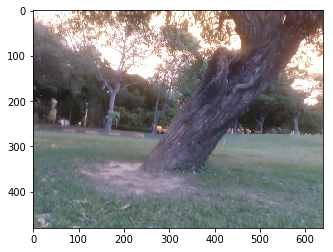

In [3]:
# '''load file'''
# npDepth = np.load(file_path+"npyD_0_6.npy")
# color = np.load(file_path+'npyC_0_6.npy')
'''load file'''
npDepth = np.load("/home/anny/109-2/0420_treeExperiment/npy/1_result/npyD_2_0.npy") # 2_result/npyD_20_0
color = np.load('/home/anny/109-2/0420_treeExperiment/npy/1_result/npyC_2_0.npy')

npDepthF = cv2.convertScaleAbs(npDepth, alpha=0.085) # 3m
npDepthF_color = cv2.applyColorMap(npDepthF, cv2.COLORMAP_JET)
%matplotlib inline
plt.imshow(cv2.cvtColor(color, cv2.COLOR_BGR2RGB))

In [4]:
def fnFilterDepth(npDepth):
    npDepth_binary = np.copy(npDepth)
    npDepth_binary = npDepth_binary.astype('float32')

    ret, npDepth_binary1 = cv2.threshold(npDepth_binary, 4500, 255, cv2.THRESH_BINARY_INV)
    ret, npDepth_binary2 = cv2.threshold(npDepth_binary, 500, 255, cv2.THRESH_BINARY)
    npDepth_binary1 = npDepth_binary1.astype('uint8')
    npDepth_binary2 = npDepth_binary2.astype('uint8')

    npDepth_binary = cv2.bitwise_and(npDepth_binary1, npDepth_binary2)
    npDepth_binary = npDepth_binary.astype('uint8')
    return npDepth_binary

In [5]:
rects = []
height,width = npDepth.shape
npDepthROI = npDepth[160:]

'''filter out 3m'''
npDepthROI = npDepth[160:]
npDepth_binary = fnFilterDepth(npDepthROI)
    

In [6]:
def fnFilterHeight(npHeight):
    ret, npHeight_binary = cv2.threshold(npHeight, 150, 255, cv2.THRESH_BINARY) # below 100mm
    npHeight_binary = npHeight_binary.astype('uint8')
    
    alpha=0.2
    param_model = npHeight_binary
    param_model = param_model.astype('uint8')
    moving_avg = np.zeros_like(param_model)
    moving_avg[param_model<=130]=int(0)
    moving_avg[param_model>130]=int(255)
    return moving_avg, npHeight_binary

In [7]:
def fnWorldCoord(npDepth):
    cx_d = 328 #424
    cy_d = 241 #241
    fx_d = 617 #424
    fy_d = 617 #424
    layer = 80 # middle point cloud
    npPointX = np.asarray(range(640))-cx_d
    npPointX = np.diag(npPointX)
    npPointX = npDepth.dot(npPointX)/ fx_d 
#     npPointX_2D = npPointX*npDepth[layer] / fx_d 
#     npPointX_2D = npPointX_2D.astype('float16')

    npPointY = np.asarray(range(320))-cy_d+160
    npPointY = np.diag(npPointY)
    theta = 0/180*np.pi
    npPointY = npPointY.dot(npDepth)/ fy_d * (-1) 
    npPointY = npPointY*np.cos(theta) + 360 # + npDepth * np.sin(theta)
    npPointY = npPointY.astype('float16')
#     npPointZ_2D = np.copy(npDepth[layer])
    npPointZ = npDepth
    return npPointY, npPointX, npPointZ
#     return npPointY, npPointX_2D, npPointZ_2D

In [8]:
npDepth.shape

(480, 640)

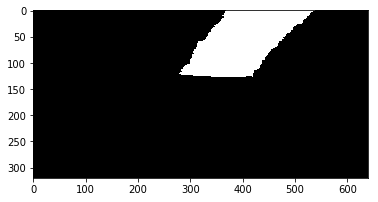

In [9]:
'''world coordinate'''
npPointY, npPointX, npPointZ = fnWorldCoord(npDepthROI)

'''filter out 5mm'''
# start_time = time.time()
npHeight = np.copy(npPointY)
npHeight = npHeight.astype('float32')
moving_avg, npHeight_binary = fnFilterHeight(npHeight)
npTreeMask = cv2.bitwise_and(npDepth_binary, moving_avg)
%matplotlib inline
plt.imshow(cv2.cvtColor(npTreeMask, cv2.COLOR_GRAY2RGB))

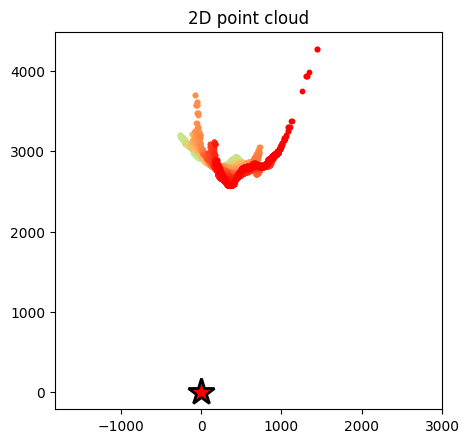

In [10]:
colors = cm.rainbow(np.linspace(1, 0, 320))

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax.axis('equal')

for i in range(319,-1,-1):
#     npPointXZ = np.vstack((npPointX[i][npTreeMask[i,:]==255],npPointZ[i][npTreeMask[i,:]==255])) 
    a = npPointX[i][npTreeMask[i,:]==255]
    b = npPointZ[i][npTreeMask[i,:]==255]
    plt.scatter(a,b, c=colors[i], s=10)
#     plt.scatter(npPointXZ[1]/1000,-npPointXZ[0]/1000, c='r', s=10)
# npPointXZ_X = np.logical_and(npPointX,npTreeMask==255)/1000*(-1)
# npPointXZ_Z = np.logical_and(npPointZ,npTreeMask==255)/1000
# npPointXZ = npPointXZ[:,npPointXZ[1,:]!=0]
# npPointXZ = npPointXZ.reshape(2,-1)
# npPointXZ = npPointXZ[:,npPointXZ[1,:]<4500]
# npPointXZ = npPointXZ.reshape(3,-1)
# base = np.ones(npPointXZ.shape[1])
# npPointXY = np.vstack((npPointXZ[1]/1000, -npPointXZ[0]/1000, base))# notice I transform coordinate

# plt.xlim([-3000,3000])
plt.plot(0, 0,linestyle='None',markersize=20, marker='*', color='r',markeredgecolor='k',markeredgewidth=2)
plt.title('2D point cloud')
# fig.colorbar(ax, ticks=[0,80,160,240,320], label='height pixel value')
# plt.colorbar(ticks=[0,80,160,240,320], label='height pixel value')
plt.show()

In [11]:
np.min(npPointZ[npTreeMask==255])

2583

In [12]:
colors = cm.rainbow(np.linspace(1, 0, 320))

fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax.axis('equal')

for i in range(319,-1,-1):
#     npPointXZ = np.vstack((npPointX[i][npTreeMask[i,:]==255],npPointZ[i][npTreeMask[i,:]==255])) 
    a = npPointX[i][npTreeMask[i,:]==255]
    b = npPointZ[i][npTreeMask[i,:]==255]
    plt.scatter(range(),b, c=colors[i], s=10)
#     plt.scatter(npPointXZ[1]/1000,-npPointXZ[0]/1000, c='r', s=10)
# npPointXZ_X = np.logical_and(npPointX,npTreeMask==255)/1000*(-1)
# npPointXZ_Z = np.logical_and(npPointZ,npTreeMask==255)/1000
# npPointXZ = npPointXZ[:,npPointXZ[1,:]!=0]
# npPointXZ = npPointXZ.reshape(2,-1)
# npPointXZ = npPointXZ[:,npPointXZ[1,:]<4500]
# npPointXZ = npPointXZ.reshape(3,-1)
# base = np.ones(npPointXZ.shape[1])
# npPointXY = np.vstack((npPointXZ[1]/1000, -npPointXZ[0]/1000, base))# notice I transform coordinate

# plt.xlim([-3000,3000])
plt.plot(0, 0,linestyle='None',markersize=20, marker='*', color='r',markeredgecolor='k',markeredgewidth=2)
plt.title('2D point cloud')
# fig.colorbar(ax, ticks=[0,80,160,240,320], label='height pixel value')
# plt.colorbar(ticks=[0,80,160,240,320], label='height pixel value')
plt.show()

(5,)

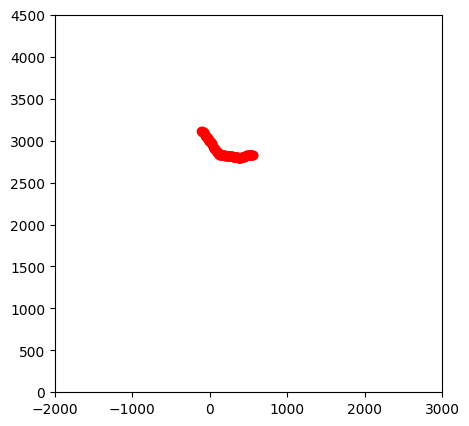

In [34]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# ax.axis('equal')
plt.xlim([-2000,3000])
plt.ylim([0,4500])
plt.scatter(npPointX[80][npTreeMask[80,:]==255],npPointZ[80][npTreeMask[80,:]==255], c='r')

plt.show()

(-2000, 3000)

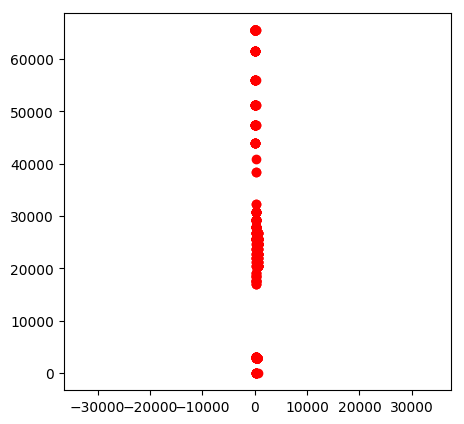

In [22]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax.axis('equal')
plt.scatter(range(640),npPointZ[80], c='r')
plt.xlim([-2000,3000])